# Классификация пар нуклеотидов: (неканоническое спаривание/нет связи) с использованием понуклеотидных классификаторов: (принадлежит неканоническому спариванию/не принадлежит неканоническому спариванию)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from f723.tools.models.application import group_k_fold
from f723.tools.dataset.features import NucleotideFeaturesExtractor, FeatureVector
from f723.tools.show.classification import show_classification_result, plot_precision_recall_curve
from f723.tools.models.nt_rnn import NucleotideRNN
from f723.tools.dataset.transformers import join_features, normalize_features, pack_neighbours, pdb_id_segments
from f723.tools.models.application import ClassificationResult
from f723.tools.show.classification import plot_precision_recall_curve
from f723.tools.dataset.utils import split_feature_vector

from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

%matplotlib inline

In [3]:
NEIGHBOURS_NUM = 5
MAX_PAIR_DIST = 60

Идея простая: возьмем RNN/Random Forest для классификации нуклеотидов. Далее делим выборку на train/test. train делим на 2 части: train_A и train_B. На train_A обучаем классификаторы нуклеотидов. Далее предсказываем для train_B и test вероятности пренадлежности нуклеотидов к неканоническому спариванию. Далее на train_B и test фитим/предиктим обычный Random Forest для пар, только теперь у нас ещё в фичах есть вероятности для нуклеотидов в паре.

In [4]:
nfe = NucleotideFeaturesExtractor(
    nrlist_path='/home/mikhail/bioinformatics/data/nrlist_3.76_3.0A.csv', 
    cif_dir='/home/mikhail/bioinformatics/data/NR_3.0/cif/', 
    out_dir='/home/mikhail/bioinformatics/data/NR_3.0/out/', 
    sec_struct_dir='/home/mikhail/bioinformatics/data/sec_struct', 
    chains_for_classification_path='/home/mikhail/bioinformatics/data/chains_for_classification.json',
    max_pair_dist=MAX_PAIR_DIST
)

In [5]:
nucleotide_feature_vector = nfe.make_dataset()

100%|██████████| 341/341 [00:46<00:00,  7.36it/s]


In [6]:
feature_vector = join_features(nucleotide_feature_vector)

In [7]:
normalized_feature_vector = normalize_features(feature_vector)
rnn_feature_vector, new_index = pack_neighbours(normalized_feature_vector, 1)

In [8]:
neighbours_feature_vector, new_index = pack_neighbours(feature_vector, NEIGHBOURS_NUM)

features = neighbours_feature_vector.features
features = features.reshape(len(features), -1)
random_forest_vector = FeatureVector(
    features=features, 
    target=neighbours_feature_vector.target[:, NEIGHBOURS_NUM], 
    pdb_ids=neighbours_feature_vector.pdb_ids)

In [9]:
target_matrix = nucleotide_feature_vector.target_matrix.tocsr()[new_index][:, new_index]

In [10]:
stem_matrix = nucleotide_feature_vector.stem_matrix.tocsr()[new_index][:, new_index].tolil()

In [11]:
relation_matrix = nucleotide_feature_vector.relation_matrix.tocsr()[new_index][:, new_index]

In [12]:
def make_pair_indices(pdb_ids, index, max_dist):
    pdb_segments = pdb_id_segments(pdb_ids[index])
    
    left_indices, right_indices = [], []
    for start, end in pdb_segments:
        for left_index in range(start, end):
            for right_index in range(left_index + 1, min(end, left_index + max_dist + 1)):
                if not stem_matrix[index[left_index], index[right_index]]:
                    left_indices.append(left_index)
                    right_indices.append(right_index)

                    left_indices.append(right_index)
                    right_indices.append(left_index)
    
    return np.array(left_indices), np.array(right_indices)


def make_ensemble_features(random_forest_vector, rnn_proba, random_forest_proba, index):
    left_indices, right_indices = make_pair_indices(random_forest_vector.pdb_ids, index, MAX_PAIR_DIST)
    
    features = np.hstack([
        random_forest_vector.features[index].astype(np.float16), 
        rnn_proba.reshape(-1, 1).astype(np.float16),
        random_forest_proba.reshape(-1, 1).astype(np.float16)])
    
    
    distance_features = np.abs(right_indices - left_indices).reshape(-1, 1).astype(np.float16)
    relation_features = np.zeros((len(left_indices), 3), dtype=np.float16)
    relation_indices = relation_matrix[index[left_indices], index[right_indices]].A[0]
    relation_features[np.arange(len(relation_indices)), relation_indices] = 1.
    pair_features = np.hstack([features[left_indices], features[right_indices], 
                               distance_features, relation_features])
    pair_target = target_matrix[index[left_indices], index[right_indices]].A[0]
    
    return pair_features, pair_target


def make_ensemble_features_plain(random_forest_vector, index):
    left_indices, right_indices = make_pair_indices(random_forest_vector.pdb_ids, index, MAX_PAIR_DIST)
    
    features = random_forest_vector.features[index]
    
    relation_features = np.zeros((len(left_indices), 3), dtype=np.uint8)
    relation_indices = relation_matrix[index[left_indices], index[right_indices]].A[0]
    relation_features[np.arange(len(relation_indices)), relation_indices] = 1
    pair_features = np.hstack([features[left_indices], features[right_indices], relation_features])
    pair_target = target_matrix[index[left_indices], index[right_indices]].A[0]
    
    return pair_features, pair_target

Сначала прогоним просто Random Forest без стекинга, чтобы сравнивать

0.0027554429892560225 0.0025621031525008353


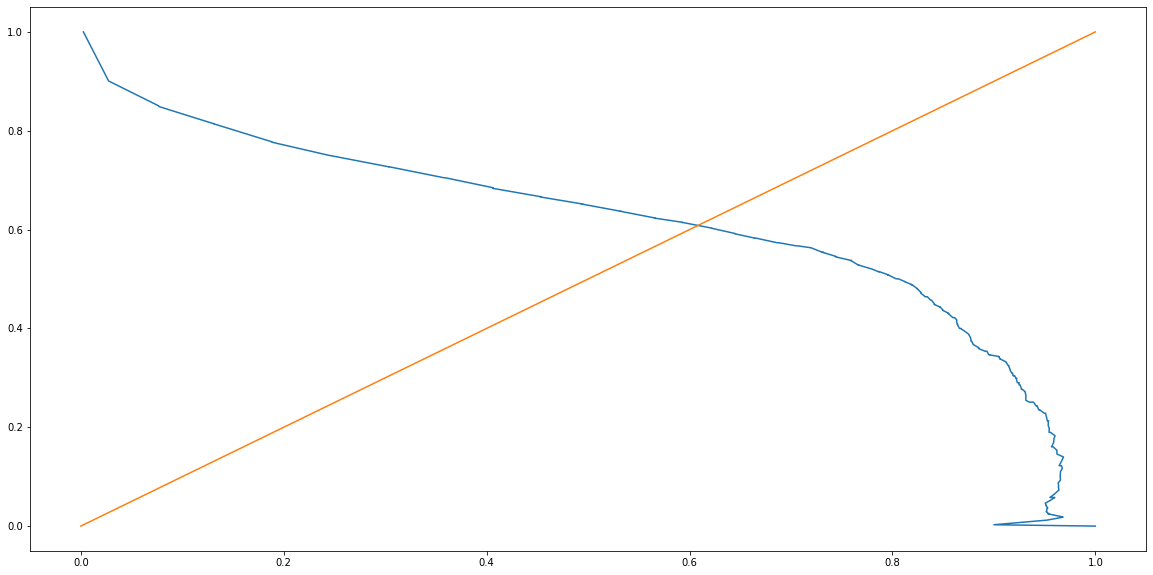

0.00274573174797889 0.0026004170597289113


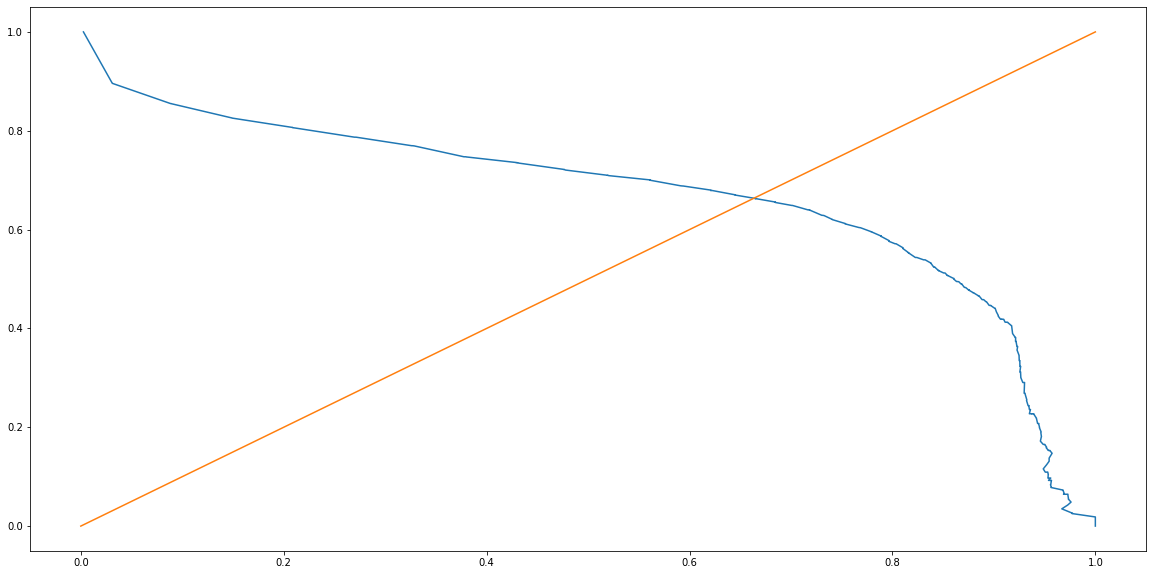

0.0026811461230456363 0.0028584295815735758


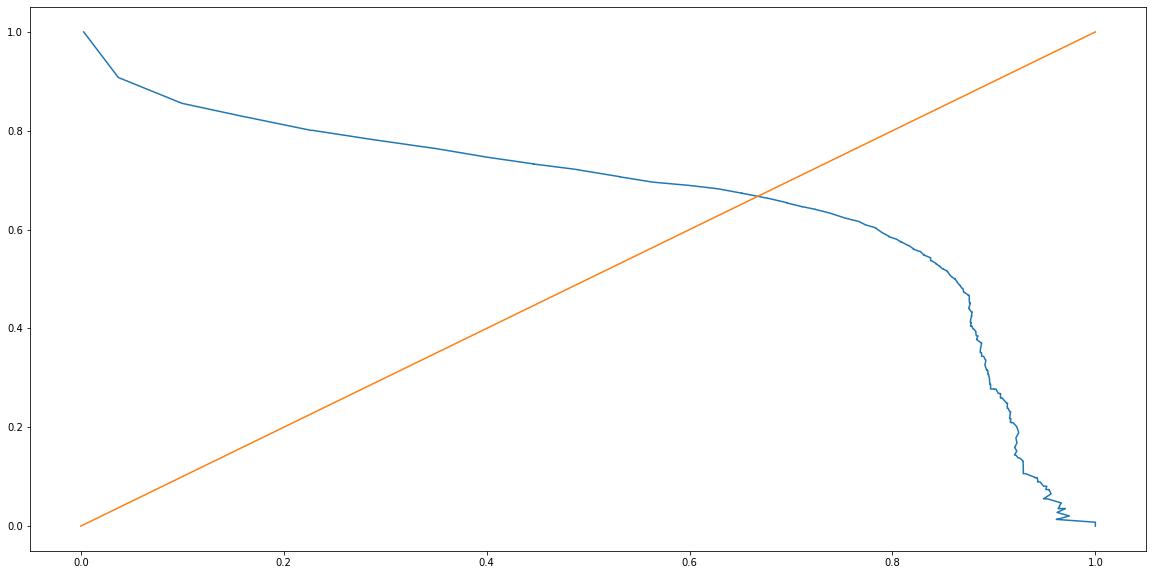

0.0026795215472376157 0.002865467392502286


KeyboardInterrupt: 

In [13]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(
    random_forest_vector.features, groups=random_forest_vector.pdb_ids)

feature_importances = []
pred_probas = []
targets = []

for train_index, test_index in group_kfold.split(
        random_forest_vector.features, groups=random_forest_vector.pdb_ids):
    X_train, y_train = make_ensemble_features_plain(random_forest_vector, train_index)
    X_test, y_test = make_ensemble_features_plain(random_forest_vector, test_index)
    print(y_train.mean(), y_test.mean())
    
    model = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    ensemble_proba = model.predict_proba(X_test)[:, 1]
    
    pred_probas.append(ensemble_proba)
    feature_importances.append(model.feature_importances_)
    targets.append(y_test)
    
    precision, recall, thresholds = precision_recall_curve(y_test, ensemble_proba)

    plt.figure(figsize=(20, 10))

    plt.plot(precision, recall)
    plt.plot([0, 1], [0, 1])
    
    plt.show()

In [ ]:
all_targets = np.array([x for xs in targets for x in xs])
all_pred_probas = np.array([x for xs in pred_probas for x in xs])

In [ ]:
np.save('ensemble_probas.npy', all_pred_probas)
np.save('ensemble_targets.npy', all_targets)

Прогоним модель со стекингом

In [14]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(
    random_forest_vector.features, groups=random_forest_vector.pdb_ids)

stacked_feature_importances = []
stacked_pred_probas = []
stacked_targets = []

for train_index, test_index in group_kfold.split(
        random_forest_vector.features, groups=random_forest_vector.pdb_ids):
    splitter = GroupShuffleSplit(train_size=0.3, test_size=0.7)
    submodels_index, stacked_index = next(splitter.split(train_index, 
                                                         groups=random_forest_vector.pdb_ids[train_index]))
    submodels_index, stacked_index = train_index[submodels_index], train_index[stacked_index]
    
    rnn = NucleotideRNN(
        neighbours_num=1, 
        batch_size=30, 
        epoch_size=1000, 
        hidden_size=128, 
        discriminator_size=5, 
        num_epochs=5,
        validation_rate=0.1)
    rnn_train, rnn_stacked, rnn_test = split_feature_vector(rnn_feature_vector, 
                                                            [submodels_index, stacked_index, test_index])
    rnn.fit(rnn_train)
    train_rnn_proba = rnn.predict_proba(rnn_stacked.features)
    test_rnn_proba = rnn.predict_proba(rnn_test.features)
    
    random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)
    X_train, X_stacked, X_test = [random_forest_vector.features[index] 
                                  for index in [submodels_index, stacked_index, test_index]]
    y_train, y_stacked, y_test = [random_forest_vector.target[index] 
                                  for index in [submodels_index, stacked_index, test_index]]
    random_forest.fit(X_train, y_train)

    train_random_forest_proba = random_forest.predict_proba(X_stacked)[:, 1]
    test_random_forest_proba = random_forest.predict_proba(X_test)[:, 1]

    X_train, y_train = make_ensemble_features(random_forest_vector, train_rnn_proba, 
                                              train_random_forest_proba, stacked_index)
    X_test, y_test = make_ensemble_features(random_forest_vector, test_rnn_proba, 
                                            test_random_forest_proba, test_index)
    print(y_train.mean(), y_test.mean())
    
    model = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    ensemble_proba = model.predict_proba(X_test)[:, 1]
    
    stacked_pred_probas.append(ensemble_proba)
    stacked_feature_importances.append(model.feature_importances_)
    stacked_targets.append(y_test)
    
    precision, recall, thresholds = precision_recall_curve(y_test, ensemble_proba)

    plt.figure(figsize=(20, 10))

    plt.plot(precision, recall)
    plt.plot([0, 1], [0, 1])
    
    plt.show()

AttributeError: module 'tensorflow.math' has no attribute 'sigmoid'

In [ ]:
all_targets = np.array([x for xs in stacked_targets for x in xs])
all_pred_probas = np.array([x for xs in stacked_pred_probas for x in xs])

In [ ]:
plain_all_targets = np.load('ensemble_targets.npy')
plain_all_pred_probas = np.load('ensemble_probas.npy')

Сравним модели по precision/recall кривым

In [ ]:
plt.figure(figsize=(20, 10))

precision, recall, thresholds = precision_recall_curve(all_targets, all_pred_probas)
plt.plot(precision, recall, c='b', label='stacked')

precision, recall, thresholds = precision_recall_curve(plain_all_targets, plain_all_pred_probas)
plt.plot(precision, recall, c='r', label='plain')

plt.plot([0, 1], [0, 1])

plt.legend(fontsize=23)

Стекинг не дает преимущества. Такое вполне может быть: в общем-то никакой дополнительной информации нуклеотидные классификаторы не дают, они просто как-то интерпретируют те же фичи и таргеты, которые и так есть в выборке.